In [ ]:
import scipy as sp
import numpy as np

import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.exceptions import NotFittedError
from scipy.stats import cauchy, laplace
from sklearn.metrics.pairwise import rbf_kernel, laplacian_kernel
from sklearn.decomposition import PCA

import torch
import torch.utils.data as Data
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as transforms
torch.manual_seed(42)

dtype = torch.float
device = torch.device("cpu")

In [ ]:
def RFF_weight(D,gamma,d):
  # D: number of random features
  # gamma: the inverse covariance
  # d: Embedding dimensions
  # outputs: 
  # W_rff: size Dxd
  # u: random shift
  W_rff = np.sqrt(2*gamma)*torch.normal(0,1,size=(D,d))
  u = 2*np.pi*torch.rand(D)
  return W_rff,u

def project_RFF(X,W_rff,u):
  # W_rff: size Dxd
  # u: random shift
  # output: projected data
  D = W_rff.shape[0]
  num_rff = W_rff.shape[1]
  Z =  np.sqrt(2/D)* torch.cos(X.mm(W_rff.T) - u.view([1,D]).expand_as( X.mm(W_rff.T) ))
  return Z


In [ ]:
num_rff=100
gamma = 1
sig_eps = 0.1
embedding_dim = 2
W_rff, u = RFF_weight(num_rff,gamma,embedding_dim)

In [ ]:
# Randomly sample data for initialization by PPCA. 
n_samples = 1000
input_dim = 10
# initial observed data
Y_t0 = torch.randn(n_samples,input_dim)

In [ ]:
# We use probPCA to initial the embedding
probPCA = PCA(n_components= embedding_dim)
probPCA.fit(Y_t0)
print(probPCA.noise_variance_)

0.9840214911630795


In [ ]:
# Step 1 - Embed the data
X_t0 = probPCA.transform(Y_t0)
X_t0 = torch.from_numpy(X_t0).float()
# Step 2 - compute their RFF representation 
Phi_t0 = project_RFF(X_t0,W_rff,u)
# Step 3 - Compute the cross-correlation matrix B = Phi_t0 Y_t0
B_t0 = (1/n_samples)*(Phi_t0.T@Y_t0)
# Step 4 - Perform the Cholesky decomposition of the regularized covariance matrix. 
A_t0 = Phi_t0.T@Phi_t0 + sig_eps*torch.eye(num_rff)
R_t0 = (1/n_samples)*torch.linalg.cholesky(A_t0)

In [ ]:
def embed_data_rff(y,W_rff,u,B,R,A,sig_eps):
  learning_rate = 1e-1
  num_iter_test = 500
  
  input_dim = y.size()[1]
  embedding_dim = W_rff.size()[1]

  x = torch.randn(1, embedding_dim, device=device, dtype=dtype,requires_grad=True)
  A_inv = torch.linalg.inv(A)

  for t in range(num_iter_test):

      Phi_x =project_RFF(x,W_rff,u)
      
      sig_x = sig_eps + sig_eps*Phi_x.mm(A_inv.mm(Phi_x.T))
      mu_x = Phi_x @ A_inv @ B
      loss = (1/input_dim) *torch.log(2*torch.pi*sig_x) + (1/(input_dim* sig_x))*(y - mu_x).pow(2).sum() + 1*x.mm(x.T)
      loss.backward()        

      with torch.no_grad():
          x -= learning_rate * x.grad
          if torch.norm(x.grad)<1e-3:
            x.grad.zero_()
            #print('early stop at iteration',t)
            return x.detach(),Phi_x.detach(),mu_x.detach(),sig_x.detach(),loss.detach()

          x.grad.zero_()

  return x.detach(),Phi_x.detach(),mu_x.detach(),sig_x.detach(),loss.detach()


def train_AB(y,Phi_x,A,B,t_step=1):
  #if t_step!=1:
  lr_t = 1e-1
  A = (1-lr_t)*A +  lr_t*Phi_x.T.mm(Phi_x)
  B = (1-lr_t)*B + lr_t*Phi_x.T.mm(y)
  return A,B

In [ ]:
A = A_t0 
B = B_t0
R = R_t0

num_training_steps = 30
loss_val = np.zeros(num_training_steps)

for training_step in range(num_training_steps):
  y = torch.randn(1, input_dim, device=device, dtype=dtype)
  x,Phi_x,mu_x,sig_x,loss = embed_data_rff(y,W_rff,u,B,R,A,sig_eps)
  A,B=train_AB(y,Phi_x,A,B)
  #print(training_step,loss)

RuntimeError: ignored

## Test on real data - USPS dataset. 

In [ ]:
dataset_USPS = datasets.USPS(root='./data',
              train=False,
              download = True,
              transform = transforms.ToTensor()
              )

  0%|          | 0/1831726 [00:00<?, ?it/s]

In [ ]:
classes = dataset_USPS.targets
print(classes)
classes_tensor = torch.FloatTensor(classes)

[9, 6, 3, 6, 6, 0, 0, 0, 6, 9, 6, 2, 2, 4, 0, 3, 1, 6, 9, 6, 2, 2, 4, 9, 6, 2, 0, 3, 8, 3, 7, 0, 5, 0, 7, 9, 5, 0, 0, 7, 0, 8, 1, 0, 7, 1, 0, 4, 2, 0, 8, 5, 1, 2, 0, 6, 5, 9, 2, 0, 9, 0, 4, 2, 0, 9, 1, 2, 2, 1, 8, 3, 7, 2, 0, 9, 0, 1, 2, 1, 2, 0, 7, 2, 0, 6, 7, 8, 2, 0, 9, 0, 4, 8, 2, 0, 7, 0, 0, 9, 0, 6, 7, 3, 0, 7, 2, 8, 9, 4, 3, 3, 9, 9, 7, 0, 5, 9, 9, 6, 8, 5, 3, 0, 6, 8, 5, 6, 1, 4, 8, 5, 0, 1, 6, 9, 0, 0, 7, 7, 9, 6, 6, 3, 3, 2, 7, 5, 0, 9, 6, 2, 2, 4, 8, 9, 1, 0, 1, 0, 2, 9, 0, 6, 0, 2, 9, 0, 3, 3, 4, 0, 9, 0, 4, 0, 8, 6, 0, 4, 1, 0, 6, 0, 4, 0, 6, 4, 1, 4, 1, 0, 1, 0, 4, 5, 7, 2, 8, 6, 3, 1, 8, 0, 5, 0, 1, 8, 0, 0, 1, 3, 8, 0, 2, 0, 6, 8, 0, 9, 0, 9, 8, 0, 3, 2, 1, 8, 0, 3, 2, 2, 4, 1, 2, 9, 6, 4, 1, 5, 2, 5, 5, 1, 6, 4, 5, 5, 1, 0, 1, 8, 4, 9, 8, 4, 6, 0, 4, 8, 4, 7, 7, 0, 8, 4, 0, 9, 2, 8, 4, 6, 0, 1, 2, 3, 6, 6, 6, 2, 3, 2, 0, 6, 6, 8, 2, 0, 1, 7, 9, 9, 7, 3, 7, 9, 9, 6, 6, 7, 9, 9, 7, 9, 9, 7, 5, 6, 8, 2, 7, 5, 6, 8, 1, 0, 1, 1, 1, 6, 7, 6, 8, 5, 0, 9, 4, 8, 1, 8, 6, 8, 5, 

In [ ]:
def get_indices(dataset,class_name):
    indices =  []
    for i in range(len(dataset.targets)):
        if dataset.targets[i] in class_name:
            indices.append(i)
    return indices

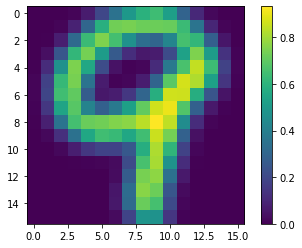

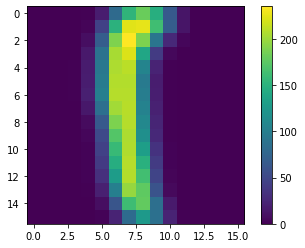

In [ ]:
plt.imshow(torch.squeeze(dataset_USPS[0][0]))
plt.colorbar()
plt.show()

for iter_k in range(1):
  plt.imshow(dataset_USPS.data[classes_tensor==1][iter_k])
  plt.colorbar()
  plt.show()

Feature batch shape: torch.Size([64, 1, 16, 16])
Labels batch shape: torch.Size([64])


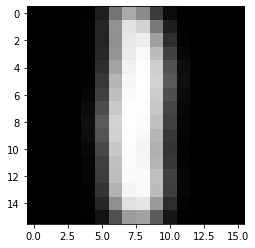

Label: 1


In [ ]:
# here we set what classes we care about to train the model 
idx = get_indices(dataset_USPS, [0,1,2,3,4])
loader = Data.DataLoader(dataset_USPS,batch_size=64, sampler = Data.sampler.SubsetRandomSampler(idx))

# Display image and label.
train_features, train_labels = next(iter(loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [ ]:
full_loader = Data.DataLoader(dataset_USPS,batch_size=len(idx), sampler = Data.sampler.SubsetRandomSampler(idx))
train_features_full, train_labels_full = next(iter(full_loader))
train_features_full_reshaped = train_features_full.reshape([len(idx),16*16])
len(idx)

1187

In [ ]:
# ProbPCA on USPS
probPCA_USPS = PCA(n_components= 2)
probPCA_USPS.fit(train_features_full_reshaped)
PCA_transf_train_features = probPCA_USPS.transform(train_features_full_reshaped)
Y_t0_USPS = train_features_full_reshaped
sig_eps = probPCA_USPS.noise_variance_
print(probPCA_USPS.noise_variance_,PCA_transf_train_features.shape)

0.041784710042862216 (1187, 2)


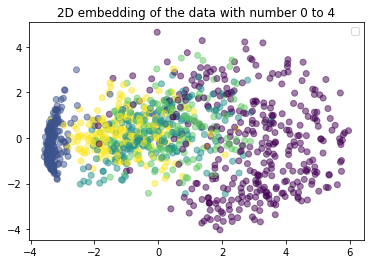

In [ ]:
plt.scatter(PCA_transf_train_features[:,0], PCA_transf_train_features[:,1],c=train_labels_full,alpha=0.5)
plt.title('2D embedding of the data with number 0 to 4')
plt.legend()
plt.show()

In [ ]:
norm_Y_t0_USPS= transforms.Normalize(Y_t0_USPS .mean(axis=0), Y_t0_USPS.mean(axis=0)

tensor([0.0031, 0.0112, 0.0303, 0.0698, 0.1327, 0.2146, 0.3106, 0.3817, 0.3496,
        0.2481, 0.1590, 0.0931, 0.0460, 0.0199, 0.0086, 0.0030, 0.0064, 0.0239,
        0.0675, 0.1497, 0.2606, 0.3743, 0.4910, 0.5827, 0.5597, 0.4411, 0.3180,
        0.2063, 0.1102, 0.0488, 0.0199, 0.0068, 0.0100, 0.0367, 0.1023, 0.2156,
        0.3420, 0.4373, 0.5189, 0.5947, 0.5923, 0.5138, 0.4224, 0.3143, 0.1901,
        0.0912, 0.0360, 0.0112, 0.0139, 0.0520, 0.1364, 0.2588, 0.3673, 0.4210,
        0.4590, 0.5132, 0.5240, 0.4876, 0.4490, 0.3823, 0.2643, 0.1412, 0.0572,
        0.0161, 0.0201, 0.0746, 0.1734, 0.2865, 0.3612, 0.3767, 0.3887, 0.4332,
        0.4509, 0.4352, 0.4274, 0.3989, 0.3100, 0.1880, 0.0839, 0.0239, 0.0318,
        0.1039, 0.2088, 0.3039, 0.3454, 0.3374, 0.3464, 0.3958, 0.4185, 0.4034,
        0.3963, 0.3834, 0.3223, 0.2187, 0.1115, 0.0363, 0.0479, 0.1324, 0.2342,
        0.3106, 0.3307, 0.3148, 0.3330, 0.3938, 0.4197, 0.3936, 0.3744, 0.3631,
        0.3169, 0.2323, 0.1341, 0.0518, 

In [ ]:
1+0*Y_t0_USPS.std(axis=0)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [ ]:
# Step 1 - Embed the data
n_samples = len(idx)
X_t0_USPS = probPCA_USPS.transform(Y_t0_USPS)
X_t0_USPS = torch.from_numpy(X_t0_USPS).float()
# Step 2 - compute their RFF representation 
Phi_t0 = project_RFF(X_t0_USPS,W_rff,u)
# Step 3 - Compute the cross-correlation matrix B = Phi_t0 Y_t0
B_t0 = (1/n_samples)*(Phi_t0.T@Y_t0_USPS)
# Step 4 - Perform the Cholesky decomposition of the regularized covariance matrix. 
A_t0 = Phi_t0.T@Phi_t0 + sig_eps*torch.eye(num_rff)
R_t0 = (1/n_samples)*torch.linalg.cholesky(A_t0)

In [ ]:
A = A_t0.detach().clone()
B = B_t0.detach().clone()
R = R_t0.detach().clone()

num_training_steps = len(idx)
loss_val = np.zeros(num_training_steps)
x_trained = np.zeros([num_training_steps,2])

sig_eps = 0.1

for training_step in range(num_training_steps):
  if training_step%50==0:
    print(training_step)

  y = train_features_full_reshaped[training_step].unsqueeze(0)
  #x_init = 
  x,Phi_x,mu_x,sig_x,loss = embed_data_rff(y,W_rff,u,B,R,A,sig_eps) #,x_init)
  if x.isnan()[0][0]==True:
    break
  x_trained[training_step][0]= x.numpy()[0][0]
  x_trained[training_step][1]= x.numpy()[0][1]

  A,B=train_AB(y,Phi_x,A,B)
  
# if training_step in range(120,126):
#   y = 10*train_features_full_reshaped[0].unsqueeze(0)
# else:
#print(training_step,loss)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150


In [ ]:
num_training_steps = len(idx)
loss_val = np.zeros(num_training_steps)
x_trained = np.zeros([num_training_steps,2])
for training_step in range(num_training_steps):
  if training_step%50==0:
    print(training_step)

  y = train_features_full_reshaped[training_step].unsqueeze(0)
  x,_,_,_,_ = embed_data_rff(y,W_rff,u,B,R,A,sig_eps)
  if x.isnan()[0][0]==True:
    break
  x_trained[training_step][0]= x.numpy()[0][0]
  x_trained[training_step][1]= x.numpy()[0][1]

# if training_step in range(120,126):
#   y = 10*train_features_full_reshaped[0].unsqueeze(0)
# else:
#print(training_step,loss)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150


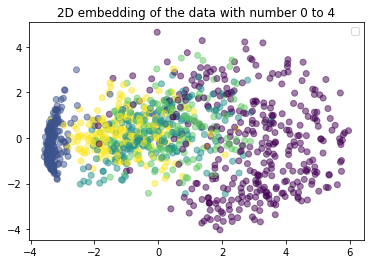

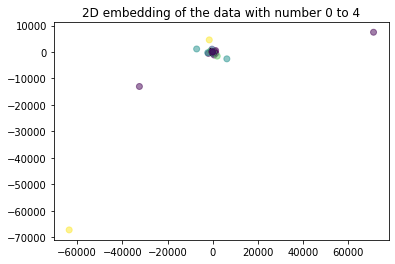

In [ ]:
plt.scatter(PCA_transf_train_features[:len(x_trained),0], PCA_transf_train_features[:len(x_trained),1],c=train_labels_full[:len(x_trained)],alpha=0.5)
plt.title('2D embedding of the data with number 0 to 4')
plt.legend()
plt.show()
plt.scatter(x_trained[:len(x_trained),0],x_trained[:len(x_trained),1],c=train_labels_full[:len(x_trained)],alpha=0.5)
#plt.scatter(torch.cat(x_trained).numpy()[:,0], torch.cat(x_trained).numpy()[:,1],c=train_labels_full[:len(x_trained)],alpha=0.5)
plt.title('2D embedding of the data with number 0 to 4')
#plt.legend(["0" , "1", "2", "3","4"])
plt.show()

In [ ]:

x_train_array = x_trained[0].numpy()

(59,)

In [ ]:
def embed_data_rff(y,W_rff,u,B,R,A):
  learning_rate = 1e-1
  num_iter_test = 500

  x = torch.randn(1, embedding_dim, device=device, dtype=dtype,requires_grad=True)
  A_inv = torch.linalg.inv(A)

  for t in range(num_iter_test):
      Phi_x =project_RFF(x,W_rff,u)
      sig_x = sig_eps + sig_eps*Phi_x.mm(A_inv.mm(Phi_x.T))
      mu_x = Phi_x @ A_inv @ B_t0
      loss = (1/input_dim) *torch.log(2*torch.pi*sig_x) + (1/(input_dim* sig_x))*(y - mu_x).pow(2).sum() + 0.5*x.mm(x.T)
      loss.backward()        
      with torch.no_grad():
          x -= learning_rate * x.grad
          x.grad.zero_()
  return x,Phi_x,mu_x,sig_x

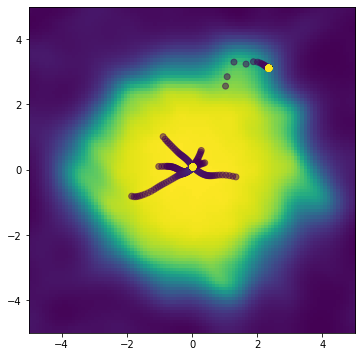

In [ ]:
# Training of the model above
y = torch.randn(1, input_dim, device=device, dtype=dtype)
fig, ax = plt.subplots(figsize=(6,6))

for iter_k in range(10):
  x = torch.randn(1, embedding_dim, device=device, dtype=dtype,requires_grad=True)

  learning_rate = 1e-1
  num_iter_test = 500
  x_val = np.zeros([num_iter_test,2])

  for t in range(num_iter_test):
      #Phi_x = np.sqrt(2/D)*torch.cos( (x@W_rff.T) + u[np.newaxis,:])
      Phi_x =project_RFF(x,W_rff,u)
      sig_x = sig_eps + sig_eps*Phi_x.mm(A_inv.mm(Phi_x.T))
      mu_x = Phi_x @ A_inv @ B_t0
      loss = (1/input_dim) *torch.log(2*torch.pi*sig_x) + (1/(input_dim* sig_x))*(y - mu_x).pow(2).sum() + 0.5*x.mm(x.T)
      loss.backward()        
      with torch.no_grad():
          x -= learning_rate * x.grad
          x.grad.zero_()
          if (t < num_iter_test):
              #print(t, loss.item())
              x_val[t][0]= x.numpy()[0][0]
              x_val[t][1]= x.numpy()[0][1]

  colors = range(num_iter_test)
  plt.scatter(x_val[:num_iter_test,0], x_val[:num_iter_test,1],c=colors[:num_iter_test],alpha=0.5)


ax.imshow(loss_landscape.detach().numpy(), interpolation='none', extent=[-5,5,-5,5])
ax.set_aspect(1) 
plt.show()

In [ ]:
x_t=torch.zeros_like(x)

loss_landscape= torch.zeros(100,100)
loss_landscape_reg= torch.zeros(100,100)
for iter_a,alpha in enumerate(torch.arange(-5, 5, 0.1)):
  for iter_b,beta in enumerate(torch.arange(-5, 5, .1)):

    x_t[0][0] = alpha
    x_t[0][1] = beta

    Phi_x =project_RFF(x_t,W_rff,u)
    sig_x = sig_eps + sig_eps*Phi_x.mm(A_inv.mm(Phi_x.T))
    mu_x = Phi_x @ A_inv @ B_t0

    loss = (1/input_dim) *torch.log(2*torch.pi*sig_x) + (1/(input_dim* sig_x))*(y - mu_x).pow(2).sum() + 0*x_t.mm(x_t.T)
    loss_reg = (1/input_dim) *torch.log(2*torch.pi*sig_x) + (1/(input_dim* sig_x))*(y - mu_x).pow(2).sum() + .5*x_t.mm(x_t.T)

    loss_landscape[iter_a][iter_b] = loss
    loss_landscape_reg[iter_a][iter_b] = loss_reg

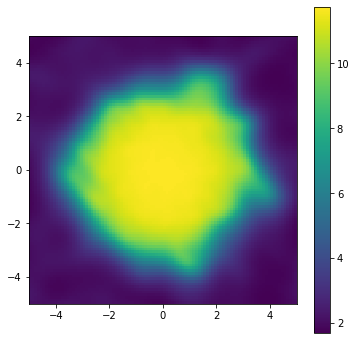

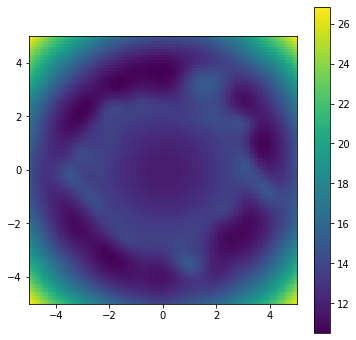

In [ ]:
#loss_landscape
fig, ax1 = plt.subplots(figsize=(6,6))
pos = ax1.imshow(loss_landscape.detach().numpy(), interpolation='none', extent=[-5,5,-5,5])
fig.colorbar(pos, ax=ax1)
ax1.set_aspect(1)
plt.show()

#loss_landscape
fig, ax2 = plt.subplots(figsize=(6,6))
pos = ax2.imshow(loss_landscape_reg.detach().numpy(), interpolation='none', extent=[-5,5,-5,5])
fig.colorbar(pos, ax=ax2)
ax2.set_aspect(1)
plt.show()


tensor([[ 0.3915, -1.2900,  0.7111, -0.5252, -1.9156, -0.9972,  0.2278, -0.4265,
         -0.6093, -2.0117]])

In [ ]:
# some data to use
# https://github.com/OleguerCanal/GPLVM/blob/master/scripts/exp_oil.py

In [ ]:
  #loss_val[training_step] = loss.numpy()[0][0]
  # A.requires_grad_()
  #A_inv = torch.linalg.inv(A)
  # B.requires_grad_()
  # sig_x = sig_eps + sig_eps*Phi_x.mm(torch.linalg.inv(A).mm(Phi_x.T))
  # mu_x = Phi_x @ torch.linalg.inv(A) @ B
  # loss = (1/input_dim) *torch.log(2*torch.pi*sig_x) + (1/(input_dim* sig_x))*(y - mu_x).pow(2).sum() + 0.5*x.mm(x.T)

  # loss.backward()        
  # learning_rate = 1e-1
  # with torch.no_grad():
  #     plt.imshow(torch.div(A.grad,Phi_x.T.mm(Phi_x)))
  #     plt.colorbar()
  #     plt.show()
  #     A -= learning_rate * A.grad
  #     A.grad.zero_()
  #     plt.imshow(torch.div(B.grad,Phi_x.T.mm(y)))
  #     plt.colorbar()
  #     plt.show()
  #     B -= learning_rate * B.grad
  #     B.grad.zero_()
  # A.requires_grad_(False)
  # B.requires_grad_(False)

$\newcommand{\c}{{\bf c}}$
$\newcommand{\W}{{\bf W}}$
$\newcommand{\A}{{\bf A}}$
$\newcommand{\M}{{\bf M}}$
$\newcommand{\X}{{\bf X}}$
$\newcommand{\Y}{{\bf Y}}$
$\newcommand{\Z}{{\bf Z}}$
$\newcommand{\z}{{\bf z}}$
$\newcommand{\C}{{\bf C}}$
$\newcommand{\y}{{\bf y}}$
$\newcommand{\eye}{{\bf I}}$
$\newcommand{\x}{{\bf x}}$
$\newcommand{\v}{{\bf v}}$
$\DeclareMathOperator{\Tr}{Tr}$


### Variable definitions

- Input or observations, $\Y \in \mathbb{R}^{D\times T} $, 
- Output or corresponding latent representation ($q < D $), $\X \in \mathbb{R}^{q\times T} $.
- whitening constant $\sigma^2$


### Likelihood

\begin{equation}
 p(\y_\star | \Y,\X,\x_\star) = \mathcal{N}(\y_\star , \mu_\star , \sigma^2_\star \eye)
\end{equation}

with the optimal mean $\mu_\star$, and variance $\sigma^2_\star$,
\begin{equation}
 [\mu_\star]_d  = \phi^\top(\x_\star) \A^{-1} \Phi \y_{:d} \sigma^2_\star \eye) \\
 \sigma^2_\star = \sigma^2_\varepsilon + \sigma^2_\varepsilon \phi^\top(\x_\star) \A^{-1} \phi^\top(\x_\star)
\end{equation}


---

### Pseudo-code

Draw vectors $\{\v_i\}_{i=1}^m$
\begin{equation}
\min_{\X} \frac{1}{2} \Tr \left[\Y^\top \Y (\sigma^2 I_T + \X^\top \X )^{-1} + n \ln\left( \sigma^2 I_T + \frac{\gamma^2}{T} \X^\top \X\right) + \X^\top \X \right ]
\end{equation}

We rewrite the optimization problem above as a minmax problem: 

\begin{equation}
\min_{\X} \max_{\M}\min_{\W}\max_{\Z}  \Tr \left[ \frac{1}{\sigma^2} ( \Y -\W\X)^\top \Z - \frac{1}{2\sigma^2} \Z^\top \Z + \frac{1}{2} \X^\top \X + \frac{T}{2\gamma^2} \W^\top \W + \frac{n}{2} \left(\sigma^2 \M + \frac{\gamma^2}{T} \X^\top \M \X - \ln(\M)\right) \right ]
\end{equation}

### Update rules/Gradients:

\begin{align}
- \partial_\X & = \frac{1}{\sigma^2} \W^\top \Z - ( I_k + n \frac{\gamma^2}{T} \M) \X \\
- \partial_\W & = \frac{1}{\sigma^2} \Z \X^\top - \frac{T}{\gamma^2} \W  \\
\partial_\Z &= \frac{1}{\sigma^2} (\Y - \W \X) - \frac{1}{\sigma^2} \Z  \\
\partial_\M &= \frac{n}{2} \left( \sigma^2 I_k + \frac{\gamma^2}{T} \X \X^\top \right) - \frac{n}{2} \M^{-1} 
\end{align}
